<a href="https://colab.research.google.com/github/ferdcoz/mcd-ast/blob/original/AST_Clase_7_ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 7 - Modelos de Ensambles</h3>
    <h3>Ejercicio 2_Sincronico</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno, Drago Braian <p>
</div>

**Modelos Ensambles**  

XGBoost:   
Es la abreviatura de las palabras inglesas "extreme gradient boosting" (refuerzo de gradientes extremo). Este método se basa en árboles de decisión y supone una mejora sobre otros métodos.  

LightGBM:
Dado que se basa en algoritmos de árbol de decisión, divide las hoja del árbol con “el mejor ajuste”, mientras que otros algoritmos de **“boosting”** que dividen el árbol de acuerdo a su niveles de profundidad en  lugar de hoja por hoja. Por lo tanto, cuando Light GBM trabaja en la misma hoja puede reducir más pérdidas que los algoritmos por niveles, dando  como resultado una mejor  precisión  que rara vez se puede lograr con los  algoritmos de refuerzo existentes. Además, es sorprendentemente muy rápido, de ahí la palabra **‘Light’**.  

Algunas diferencias relevantes de los modelos son por ejemplo que debido a los métodos de división que utiliza **XGBoost** (que requieren que los datos se ordenen previamente y se agrupen antes de dividirlos), no es muy eficiente en cuanto a memoria y los conjuntos de datos grandes pueden causar problemas de falta de memoria. De manera adicional debido a que construye árboles primero en profundidad (es decir, bajando los niveles del árbol), puede llevar más tiempo encontrar árboles con menor error. También es de destacar que XGBoost no puede manejar variables categóricas de forma nativa; Depende de usted codificarlos antes del entrenamiento.

En comparación, **LightGBM** tiende a ser más eficiente en cuanto a el trabajo requerido por CPU-MEMORIA y suele desempeñarse mejor con datasets grandes.  
Esto se logra en gran parte por sus métodos, cómo GOSS, que significa "Gradient-based One-Side Sampling," cuya idea es reducir la cantidad de datos que se utilizan para entrenar cada árbol de decisión, mientras se mantiene la calidad de la información utilizada. Además, LGBM puede manejar variables categóricas de forma nativa.

**Objetivo del Ejercicio**: A traves del dataset disponible, el cual representa la usabilidad por hora del sistema de Bicicletas Publicas de la ciudad de Washington, D.C. entre 2011 y 2012. Debe elaborarse un modelo de ML utilizando un modelo de ensamblado, para predecir el número de usuarios dentro de las proximas 36 horas.  

Porque? Con esta información se puede planificar mejor la redistribución de Bicicletas.

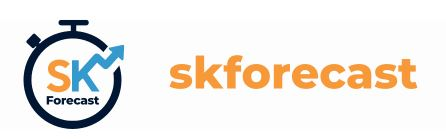

https://skforecast.org/0.10.0/index.html

In [ ]:
!pip install skforecast session_info

Carga de Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import warnings

# Carga y Procesamiento inicial del dataset

In [ ]:
url = 'https://raw.githubusercontent.com/braiandrago/AST/main/bike_sharing_dataset_clean.csv'

In [ ]:
bicicles = pd.read_csv(url,parse_dates=[1])
bicicles['date_time'] = pd.to_datetime(bicicles['date_time'], format='%Y-%m-%d %H:%M:%S')
bicicles = bicicles.set_index('date_time')
bicicles = bicicles.asfreq('H')
bicicles = bicicles.sort_index()
bicicles = bicicles.drop(columns=['workingday'])
bicicles.head()
print(bicicles.shape)
bicicles.head()

(17544, 10)


holiday weather  temp   atemp   hum  windspeed  users  \
date_time                                                                   
2011-01-01 00:00:00     0.0   clear  9.84  14.395  81.0        0.0   16.0   
2011-01-01 01:00:00     0.0   clear  9.02  13.635  80.0        0.0   40.0   
2011-01-01 02:00:00     0.0   clear  9.02  13.635  80.0        0.0   32.0   
2011-01-01 03:00:00     0.0   clear  9.84  14.395  75.0        0.0   13.0   
2011-01-01 04:00:00     0.0   clear  9.84  14.395  75.0        0.0    1.0   

                     month  hour  weekday  
date_time                                  
2011-01-01 00:00:00      1     0        5  
2011-01-01 01:00:00      1     1        5  
2011-01-01 02:00:00      1     2        5  
2011-01-01 03:00:00      1     3        5  
2011-01-01 04:00:00      1     4        5

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create a list of available columns
available_columns = bicicles.columns.tolist()

# create initial visible traces
visible = [True] * len(available_columns)

# create subplot
fig = make_subplots()

# add traces
for i, column in enumerate(available_columns):
    trace = go.Scatter(x=bicicles.index, y=bicicles[column], name=column, visible=visible[i])
    fig.add_trace(trace)

# update layout
fig.update_layout(
    updatemenus=[
        dict(
            type='dropdown',
            active=0,
            buttons=list(
                [
                    dict(label='All',
                         method='update',
                         args=[{'visible': [True] * len(available_columns)},
                               {'yaxis': {'title': 'Values'}}]),
                    dict(label='None',
                         method='update',
                         args=[{'visible': [False] * len(available_columns)},
                               {'yaxis': {'title': 'Values'}}])
                ] + [
                    dict(label=column,
                         method='update',
                         args=[{'visible': [column == col for col in available_columns]},
                               {'yaxis': {'title': column}}])
                    for column in available_columns
                ]
            )
        )
    ])

# update x-axis
fig.update_xaxes(
    tickmode='linear',
    tick0=bicicles.index[0],
    dtick='M1',
    tickformat='%Y-%m-%d')

# show plot
fig.show()

Dividimos en train, valid y test:

In [ ]:
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = bicicles.loc[: end_train, :]
data_val   = bicicles.loc[end_train:end_validation, :]
data_test  = bicicles.loc[end_validation:, :]

In [ ]:
bicicles.loc[:end_train, 'partition'] = 'train'
bicicles.loc[end_train:end_validation, 'partition'] = 'validation'
bicicles.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = bicicles.reset_index(),
    x      = 'date_time',
    y      = 'users',
    color  = 'partition',
    title  = 'Number of users',
    width  = 800,
    height = 450
)
fig.update_layout(
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()
data=bicicles.drop(columns='partition')

Estacionalidad

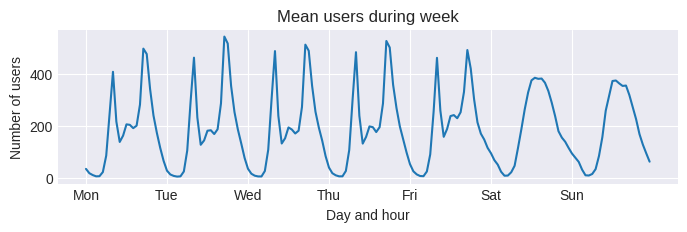

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2))
mean_day_hour = data.groupby(["weekday", "hour"])["users"].mean()
mean_day_hour.plot(ax=ax)
ax.set(
    title="Mean users during week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Day and hour",
    ylabel="Number of users"
);

Diagramas de Autocorrelaciones:

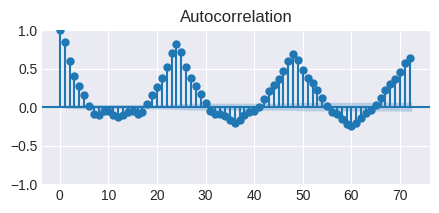

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

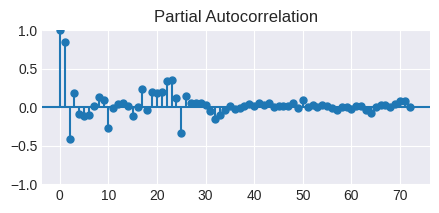

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data['users'], ax=ax, lags=72, method='ywm')
plt.show()

Se observan fuertes correlaciones en lags pasados,los cuales podrías ser buenos predictores. Esto significa que conocer la cantidad de usuarios durante ciertos períodos en el pasado podría ser valioso para predecir la cantidad de usuarios en el futuro.

**Elaboración del Modelo**

1. Primero, se entrena un modelo autorregresivo utilizando valores pasados ​​(retrasos) de la variable de respuesta como predictores.  
2. Posteriormente se añaden variables exógenas al modelo y se evalúa la mejora en su desempeño.


Los modelos de aumento de gradiente tienen una gran cantidad de hiperparámetros, por lo que se utiliza una combinación de estrategia grid_search y backtesting para identificar la mejor configuración que brinde las predicciones más precisas.

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags = 24
             )

**Hyperparameter tuning:**  
Para evitar Overfitting, se realiza una búsqueda en la que cada combinación de hiperparámetros y retrasos se prueba de la siguiente manera:

-Entrene el modelo usando solo el conjunto de entrenamiento.

-El modelo se evalúa utilizando el conjunto de validación mediante backtesting.

-Se selecciona la combinación de hiperparámetros y retrasos que produce el error más bajo.

-Vuelva a entrenar el modelo utilizando la mejor combinación encontrada, esta vez utilizando tanto los datos de entrenamiento como los de validación.

In [ ]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 13132.573900322006



In [ ]:
results_grid.head()

lags  \
21  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
20  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params  mean_squared_error  \
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...        13132.573900   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...        14407.853484   
9   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...        14677.093172   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...        14959.220470   
7   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        15135.992088   

    learning_rate  max_depth  n_estimators  
21            0.1        5.0         500.0  
20            0.1        5.0         100.0  
9             0.1        5.0         500.0  
22            0.1       10.0         100.0  
7             0.1        3.0         500.0

Dado que return_best = True, el objeto del pronosticador se actualizará con la mejor configuración encontrada y entrenada en todo el conjunto de datos. Esto significa que el modelo final obtenido de la búsqueda de cuadrícula tendrá la mejor combinación de retrasos e hiperparámetros que dieron como resultado la métrica de rendimiento más alta. Este modelo final se puede utilizar para futuras predicciones sobre nuevos datos.


**Baktesting - Time Series Split**
Una vez identificada la mejor combinación de hiperparámetros utilizando los datos de validación, se evalúa la capacidad predictiva del modelo cuando se aplica al conjunto de prueba. La función backtesting_forecaster se utiliza para simular el proceso de predicción cada 36 horas.
Esto ayudará a utilizar todo su potencial para analizar la capacidad predictiva del modelo.

In [ ]:
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['users'],
                            initial_train_size = len(data.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps              = 36,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False # Change to True to see detailed information
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()

  0%|          | 0/82 [00:00<?, ?it/s]

Backtest error: 11600.73


pred
2012-09-01 00:00:00  127.918144
2012-09-01 01:00:00   73.119354
2012-09-01 02:00:00   44.164623
2012-09-01 03:00:00   22.474485
2012-09-01 04:00:00    8.992602

Predicciones vs. Valores reales:

In [ ]:
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Users",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

**Variables Exogenas:**

Aunque las variables 'mes', 'día laborable', 'clima' y 'vacaciones' se almacenan como valores numéricos, en realidad son variables categóricas. Por lo tanto, es importante convertir su tipo de datos a categóricos para evitar que el modelo los interprete como características numéricas. Esto ayudará a garantizar que el modelo sea capaz de capturar con precisión las características y patrones únicos de estas variables.

La clase **OneHotEncoder** en scikit-learn se puede utilizar para transformar cualquier característica categórica con n valores posibles en n nuevas características binarias, donde una de ellas toma el valor 1 y todas las demás toman el valor 0.

**ColumnTransformers** en scikit-learn proporciona una forma poderosa de definir transformaciones y aplicarlas a características específicas. Al encapsular las transformaciones en un objeto ColumnTransformer, se puede pasar a un pronosticador utilizando el argumento transformador_exog.

In [ ]:
# Store categorical variables as category type
data["holiday"] = data["holiday"].astype("category")
data["weather"] = data["weather"].astype("category")
data["month"]   = data["month"].astype("category")
data["weekday"] = data["weekday"].astype("category")

In [ ]:
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor        = XGBRegressor(random_state=123),
                 lags             = 24,
                 transformer_exog = one_hot_encoder
             )

In [ ]:
# View Training Matrix
exog_features = ['weather', 'month', 'weekday', 'hour', 'holiday',
                 'temp', 'atemp', 'hum', 'windspeed']

X_train, y_train = forecaster.create_train_X_y(
                        y = data.loc[:end_validation, 'users'],
                        exog = data.loc[:end_validation, exog_features]
                   )
X_train.head(3)

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
date_time                                                                     
2011-01-02 00:00:00   39.0   28.0   34.0   36.0   37.0   35.0   67.0   93.0   
2011-01-02 01:00:00   17.0   39.0   28.0   34.0   36.0   37.0   35.0   67.0   
2011-01-02 02:00:00   17.0   17.0   39.0   28.0   34.0   36.0   37.0   35.0   

                     lag_9  lag_10  ...  weekday_3  weekday_4  weekday_5  \
date_time                           ...                                    
2011-01-02 00:00:00  110.0   106.0  ...        0.0        0.0        0.0   
2011-01-02 01:00:00   93.0   110.0  ...        0.0        0.0        0.0   
2011-01-02 02:00:00   67.0    93.0  ...        0.0        0.0        0.0   

                     weekday_6  holiday_1.0  hour   temp   atemp    hum  \
date_time                                                                 
2011-01-02 00:00:00        1.0          0.0     0  18.86  22.725   88.0   
2011-01-02 01:00:00        1.0          0.0     1  18.04  21.970   94.0   
2011-01-02 02:00:00        1.0          0.0     2  17.22  21.210  100.0   

                     windspeed  
date_time                       
2011-01-02 00:00:00    19.9995  
2011-01-02 01:00:00    16.9979  
2011-01-02 02:00:00    19.0012  

[3 rows x 52 columns]

Hiperparametrizacion:

In [ ]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 10707.383229828876



In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

  0%|          | 0/82 [00:00<?, ?it/s]

Backtest error: 6613.28


In [ ]:
# Extract feature importances
importance = forecaster.get_feature_importances()
importance

feature  importance
0       lag_1    0.291201
1       lag_2    0.007887
2       lag_3    0.018174
3       lag_4    0.015185
4       lag_5    0.002496
..        ...         ...
71       hour    0.101459
72       temp    0.002402
73      atemp    0.003456
74        hum    0.001782
75  windspeed    0.001386

[76 rows x 2 columns]

**Elaboración de Modelo con LightGBM**

La codificación ordinal u **Ordinal Encoding** es una técnica utilizada para convertir variables categóricas en variables numéricas. A cada categoría se le asigna un valor numérico único en función de su orden o rango, según lo determinado por un criterio elegido, como la frecuencia o la importancia. Este método de codificación es particularmente útil cuando las categorías tienen un orden o clasificación natural, como las calificaciones educativas. Sin embargo, es importante señalar que los valores numéricos asignados a cada categoría no representan ninguna diferencia numérica inherente entre ellas, sino que simplemente proporcionan una representación numérica.

In [ ]:
pipeline_categorical = make_pipeline(
                           OrdinalEncoder(
                               dtype=int,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1,
                               encoded_missing_value=-1
                           ),
                           FunctionTransformer(
                               func=lambda x: x.astype('category'),
                               feature_names_out= 'one-to-one'
                           )
                       )

transformer_exog = make_column_transformer(
                       (
                           pipeline_categorical,
                           make_column_selector(dtype_exclude=np.number)
                       ),
                       remainder="passthrough",
                       verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(categorical_features='auto', random_state=123),
                lags = 24,
                transformer_exog = transformer_exog
             )

In [ ]:
# View Training Matrix
exog_features = ['weather', 'month', 'weekday', 'hour', 'holiday',
                 'temp', 'atemp', 'hum', 'windspeed']

X_train, y_train = forecaster.create_train_X_y(
                        y = data.loc[:end_validation, 'users'],
                        exog = data.loc[:end_validation, exog_features]
                   )
X_train.head(3)

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
date_time                                                                     
2011-01-02 00:00:00   39.0   28.0   34.0   36.0   37.0   35.0   67.0   93.0   
2011-01-02 01:00:00   17.0   39.0   28.0   34.0   36.0   37.0   35.0   67.0   
2011-01-02 02:00:00   17.0   17.0   39.0   28.0   34.0   36.0   37.0   35.0   

                     lag_9  lag_10  ...  lag_24  weather  month  weekday  \
date_time                           ...                                    
2011-01-02 00:00:00  110.0   106.0  ...    16.0        1      0        6   
2011-01-02 01:00:00   93.0   110.0  ...    40.0        1      0        6   
2011-01-02 02:00:00   67.0    93.0  ...    32.0        1      0        6   

                     holiday  hour   temp   atemp    hum  windspeed  
date_time                                                            
2011-01-02 00:00:00        0     0  18.86  22.725   88.0    19.9995  
2011-01-02 01:00:00        0     1  18.04  21.970   94.0    16.9979  
2011-01-02 02:00:00        0     2  17.22  21.210  100.0    19.0012  

[3 rows x 33 columns]

Hiperparametrización

In [ ]:
warnings.filterwarnings('ignore')
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Ac

In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )
print(f"Backtest error: {metric:.2f}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] categorical_feature is set with categorical_column=72,73,74,75, categorical_features=auto will be ignored. Current value: categorical_feature=72,73,74,75
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18638
[LightGBM] [Info] Number of data points in the train set: 14544, number of used features: 81
[LightGBM] [Info] Start training from score 178.556724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

  0%|          | 0/82 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

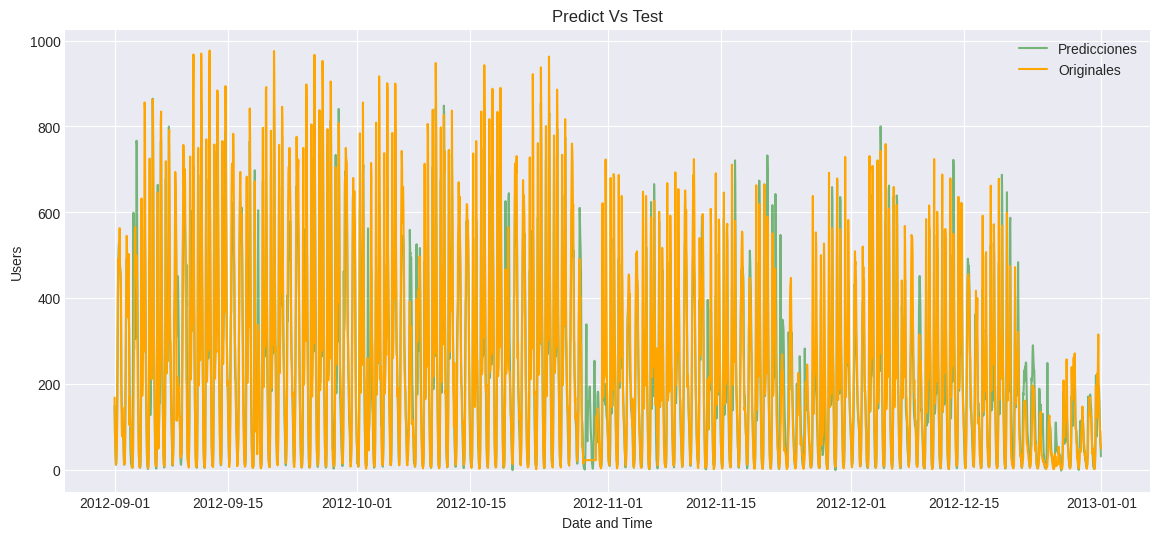

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plt.plot(predictions['pred'], color='green',label='Predicciones', alpha=0.5)
plt.plot(data_test['users'], color='orange', markersize=6, label='Originales')
plt.title('Testing data')
plt.xlabel('Date and Time')
plt.ylabel('Users')
plt.title('Predict Vs Test')
plt.legend(loc='best')
plt.show()

Resumen:


| Model                         | Exogenous features  | MSE backtest |
|:------------------------------|:-------------------:|-------------:|
| LGBMRegressor                 | True                | 6485         |
| XGBRegressor                  | True                | 6613         |
| XGBRegressor                  | False               | 11601        |